In [38]:
'''
Мы имеем данные мобильного приложения!

installs — содержит данные об установках приложения по дням.

DeviceID — идентификатор устройства, на которое было установлено приложение;
InstallationDate — дата установки приложения;
InstallCost — цена установки приложения в рублях;
Platform — платформа, на которой было установлено приложение (iOS/ Android);
Source — источник установки приложения (магазин приложения/ рекламная система/ переход с сайта).


events — содержит данные о том, как активно пользователи просматривают товары в приложении по дням.

DeviceID — идентификатор устройства, на котором используется приложение;
AppPlatform — платформа, на которой используется приложение (iOS/ Android);
EventDate — дата, за которую собрана статистика;
events — количество просмотров всех товаров за этот день у этого DeviceID.


checks — содержит данные о покупках пользователей в приложении по дням

UserID — идентификатор пользователя;
Rub — суммарный чек пользователя на дату;
BuyDate — дата, за которую собрана статистика.


devices – чтобы просмотры и установки можно было объединить с покупками

DeviceID — идентификатор устройства;
UserID — идентификатор пользователя.
'''

In [9]:
'''
Цель: посмотреть данные в разрезах.

1. Доли в % установок по платформам;
2. Выясним, пришедшие пользователи с какого источника (Source) совершили больше всего покупок;
3. Посмотрим наиболее популярные источники установки, вангую это 27. Но будут ли соотв. источники 9 и 14 покупкам?
4. Повторные покупки пользователей с каких источников делали чаще;
5. Суммы покупок по месяцам в разбивке по ios и android;
6. Динамика установок приложения по 'ios' и 'android'.
'''

In [1]:
# Импортируем либы и подключашки
from some import *

In [2]:
# пишем запрос, смотрим, что все работает
q = """
select uniq(DeviceID)
from default.installs
"""
df = ph.read_clickhouse(q, connection=connection)
df

,uniq(DeviceID)
0,11269758


In [43]:
# Диапозон дат в таблицах installs, events, checks
from queries import installs_dates, events_dates, checks_dates


q1 = installs_dates()
df = ph.read_clickhouse(q1, connection=connection)
print('installs:')
print(df)

q2  = events_dates()
df2 = ph.read_clickhouse(q2, connection=connection)
print('\n','events:')
print(df2)

q3  = checks_dates()
df3 = ph.read_clickhouse(q3, connection=connection)
print('\n','checks:')
print(df3)

installs:
    min_date   max_date
0 2019-01-01 2019-10-04

 events:
    min_date   max_date
0 2019-01-01 2019-10-04

 checks:
    min_date   max_date
0 2019-01-01 2019-10-04


In [49]:
# task 1: выгрузим количество установок приложения по платформам
from queries import count_installs_by_platform

q1 = count_installs_by_platform()
df = ph.read_clickhouse(q1, connection=connection)
# Создаю доп. колонку с долями 
df['share'] = df['cnt'] / df['cnt'].sum()*100
df


,Platform,cnt,share
0,WindowsPhone,10177,0.090386
1,iOS,2061191,18.306270
2,android,9188113,81.603344


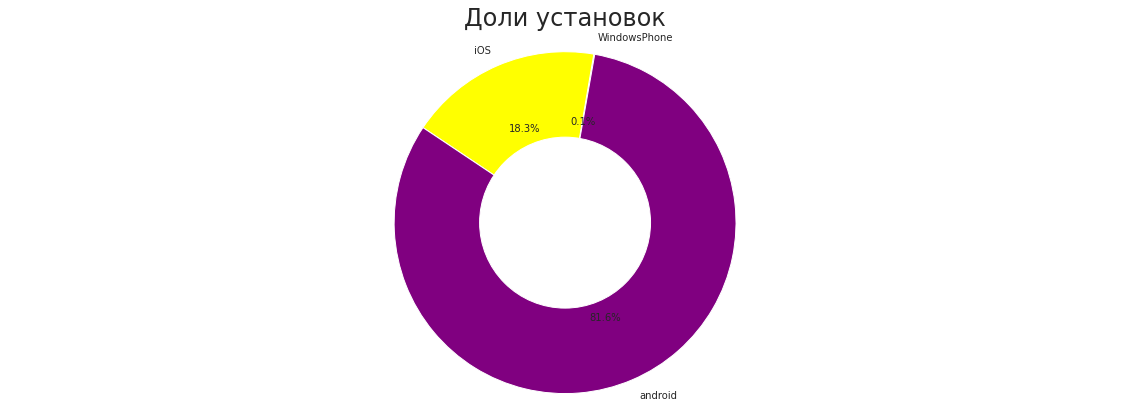

In [22]:
labels = df['Platform']
values = df['share']

fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=80, colors=['red', 'yellow', 'purple'], textprops={'fontsize': 10})
ax.axis('equal')
ax.set_title('Доли установок')

center_circle = plt.Circle((0, 0), 0.5, color='white')
ax.add_artist(center_circle)

plt.show()

Ответ: платформа 'android' является наиболее популярной по установкам приложения, доля 'windows' очень мала

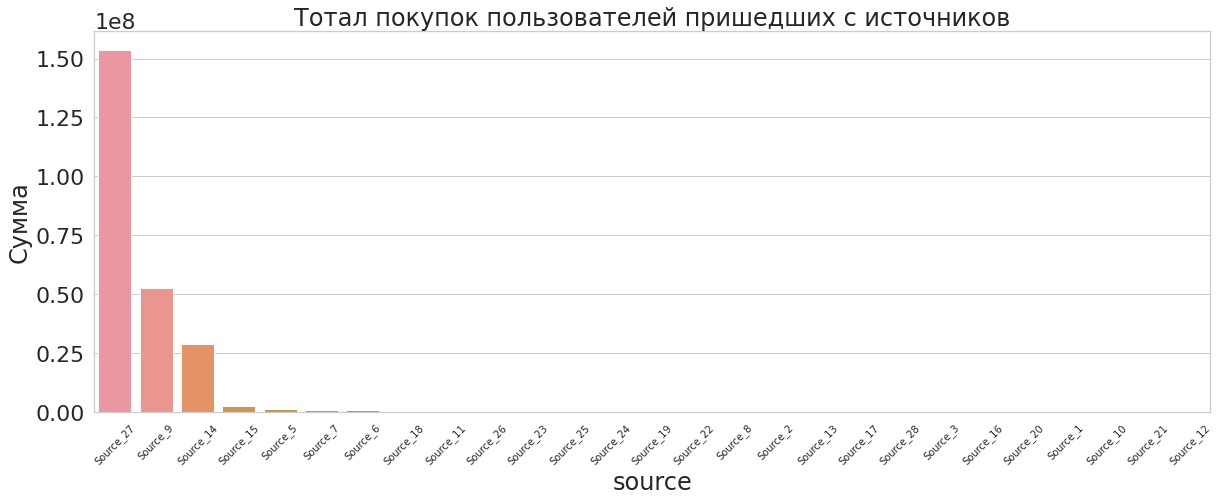

In [40]:
# 2. Выясним, пришедшие пользователи с какого источника (Source) совершили больше всего покупок
from queries import total_bought_by_source

q1 = total_bought_by_source()
df = (ph
      .read_clickhouse(q1, connection=connection)
      .sort_values('total_sum', ascending=False)
      )
import seaborn as sns

x = df['source']
y = df['total_sum']

ax = sns.barplot(x=x, y=y)

plt.ylabel('Сумма')
plt.title('Тотал покупок пользователей пришедших с источников')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10)

plt.show()

Ответ: Основной источник скачивания приложения с которого приходит доход - Source_27, менее популярные 9 и 14 источники.

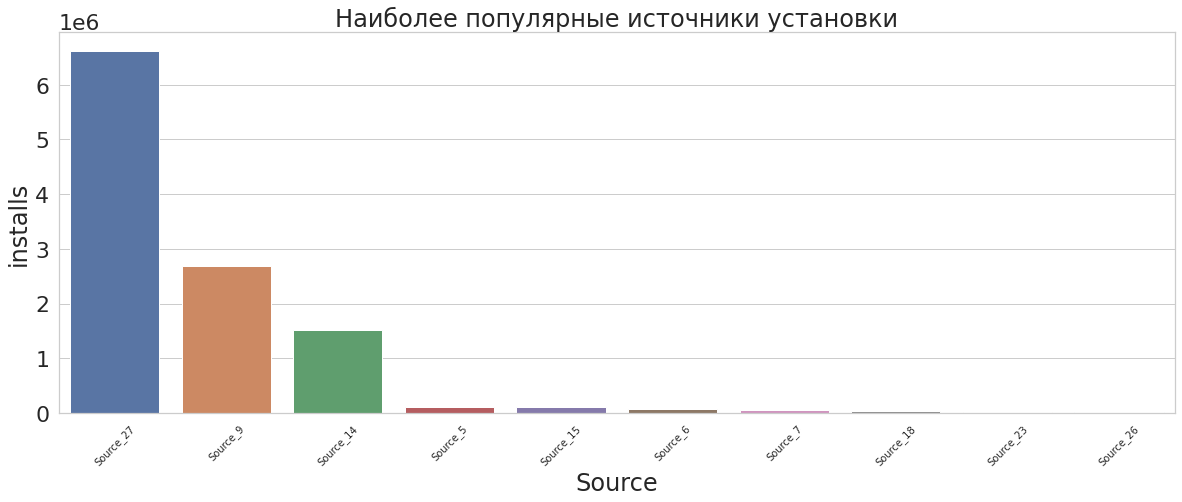

In [42]:
# 3. А теперь посмотрим наиболее популярные источники установки, вангую это 27. Но будут ли соотв. источники 9 и 14 покупкам?
#    Для удобства возьму топ 10 установок
from queries import installs_by_source

q1 = installs_by_source()
df = (ph
      .read_clickhouse(q1, connection=connection)
      .sort_values('installs', ascending=False)
      )

x = df['Source']
y = df['installs']

ax = sns.barplot(x=x, y=y)
plt.ylabel('installs')
plt.title('Наиболее популярные источники установки')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10)

plt.show()

Ответ: Первые 3 источника соотв. скачиваниям. Немного поменялись местами источники 5 и 15, 6 и 7

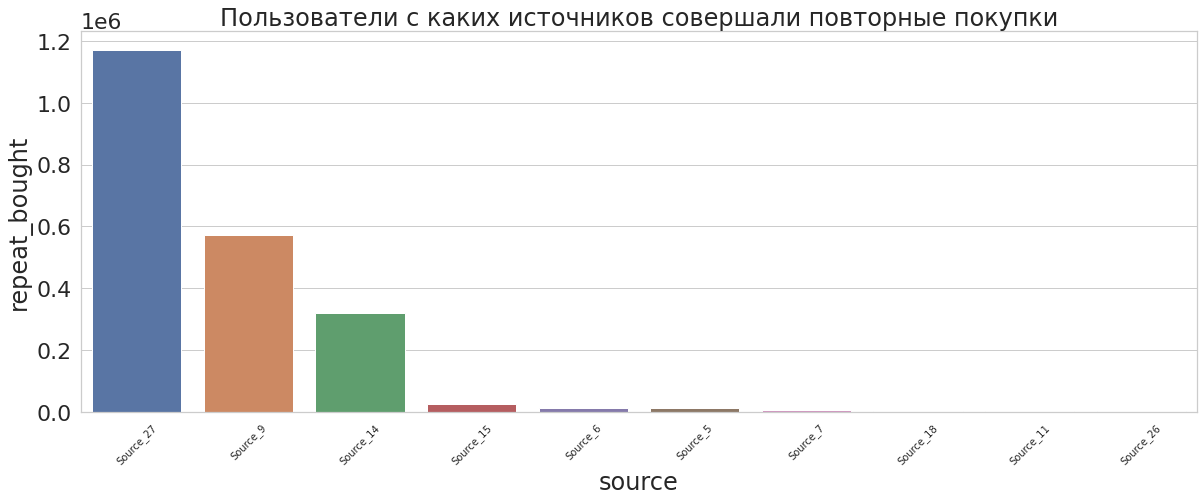

In [44]:
# 4. Повторные покупки пользователей с каких источников делали чаще
from queries import repeat_bought_by_source

q1 = repeat_bought_by_source()
df = (ph
      .read_clickhouse(q1, connection=connection)
      .sort_values('repeat_bought', ascending=False)
      .head(10)
      )

x = df['source']
y = df['repeat_bought']

ax = sns.barplot(x=x, y=y)
plt.ylabel('repeat_bought')
plt.title('Пользователи с каких источников совершали повторные покупки')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10)

plt.show()

Ответ: По повторным покупкам наблюдается приблизительно одинаковая картина по динамике

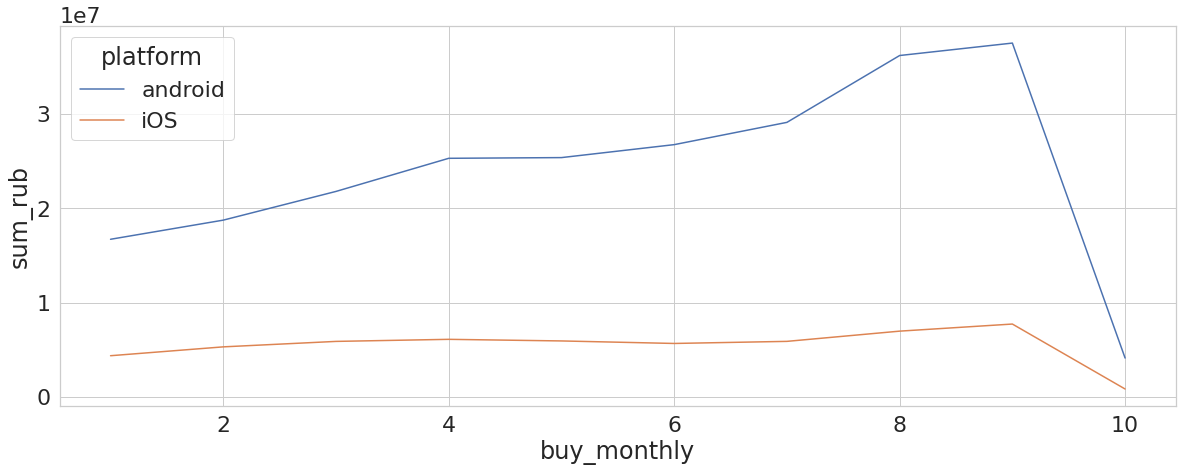

In [46]:
# 5. суммы покупок по месяцам в разбивке по ios и android
from queries import purchases_by_monthly

q1 = purchases_by_monthly()
df = ph.read_clickhouse(q1, connection=connection)

sns.lineplot(x="buy_monthly", y="sum_rub",
             hue="platform", data=df)

Ответ: Самая активная динамика покупок у пользователей 'android'. Стоит отметить, что заметный всплеск был в Июле. 'ios' показывает ровный график без каких-либо всплесков

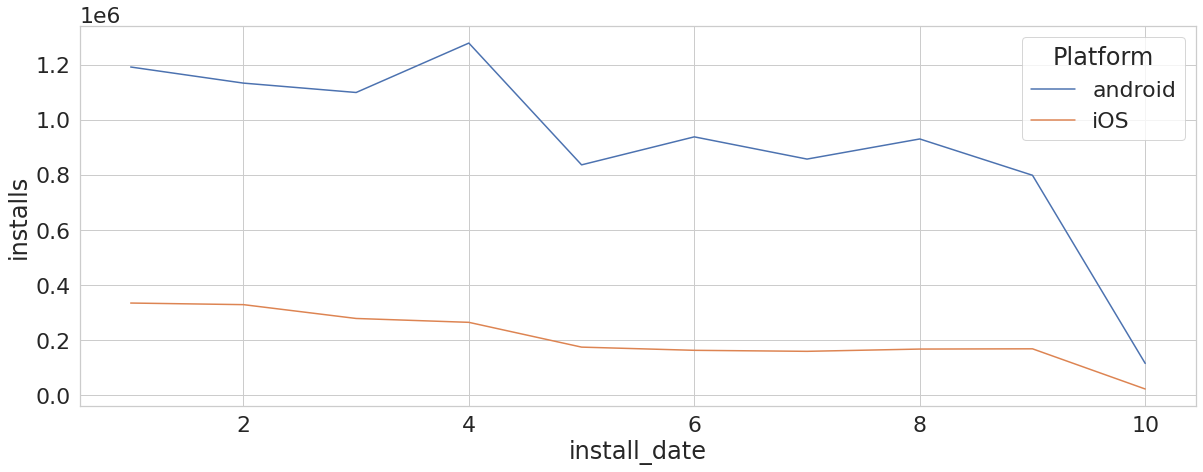

In [48]:
# 6. А теперь посмотрим динамику установок приложения по 'ios' и 'android'
from queries import installs_by_monthly

q1 = installs_by_monthly()
df = ph.read_clickhouse(q1, connection=connection)

sns.lineplot(x="install_date", y="installs",
             hue="Platform", data=df)

Ответ: график показывает, что приложение активно устанавливали до Апреля, после установки упали в перешли в стабильность.